## RandomForest

__배깅의 대표적인 알고리즘__

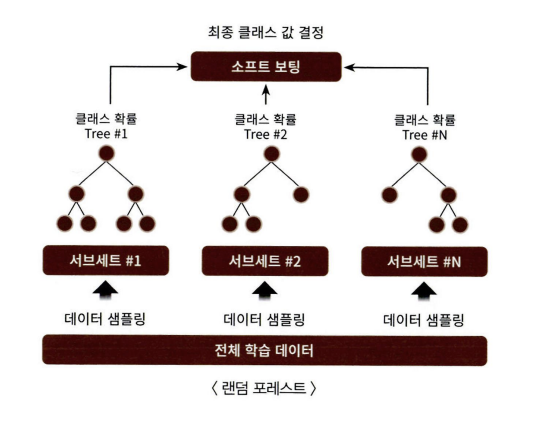

__각각의 분류기들은 Bootstrapping으로 데이터 샘플링__

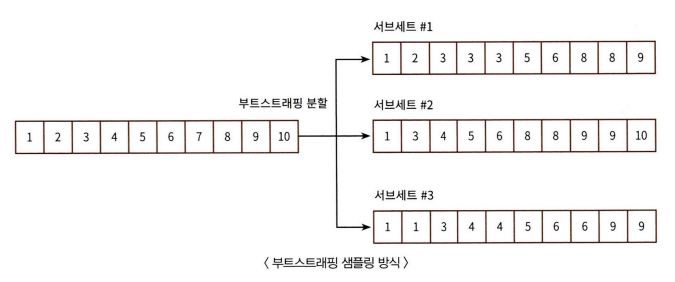



************

### Human Activity Using Smartphone dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 Dataframe으로 로드
feature_name_df = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\1.Classification\3.Decision_Tree\datasets\UCI HAR Dataset\features.txt',
                              sep='\s+', header=None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


> 인체의 움직임과 관련된 속성의 평균/표준편차가 X, Y, Z축 값으로 돼 있음을 유추할 수 있다. <br>
> features.txt 파일은 중복된 피처명을 가지고 있다. 이 중복된 피처명들을 이용해 데이터 파일을 데이터 세트 DataFrame에 로드하면 오류가 발생한다. <br>
> 따라서 중복된 피처명에 대해서는 원본 피처명에서 _1 또는 _2를 추가로 부여해 변경한 뒤에 이를 이용해 DataFrame에 로드

In [3]:
# 중복된 피처명의 개수 구해보기
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


> 총 42개의 피처명이 중복돼 있다. <br>
> 이 중복된 피처명에 대해서는 원본 피처명에 _1 또는 _2 를 추가로 부여해 새로운 피처명을 가지는 DataFrame을 반환하는 함수인 get_new_feature_name_df()를 생성

In [4]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                               if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [5]:
import pandas as pd

def get_human_datasets():

    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\1.Classification\3.Decision_Tree\datasets\UCI HAR Dataset\features.txt',
                              sep='\s+', header=None, names=['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\1.Classification\3.Decision_Tree\datasets\UCI HAR Dataset\train\X_train.txt',
                          sep='\s+', names=feature_name)
    X_test = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\1.Classification\3.Decision_Tree\datasets\UCI HAR Dataset\test\X_test.txt',
                          sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여.
    y_train = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\1.Classification\3.Decision_Tree\datasets\UCI HAR Dataset\train\y_train.txt',
                          sep='\s+', names=['action'])
    y_test = pd.read_csv(r'C:\Users\hanjieun_2\Desktop\개인공부\algorithms\1.ML\1.Supervised_Learning\1.Classification\3.Decision_Tree\datasets\UCI HAR Dataset\test\y_test.txt',
                          sep='\s+', names=['action'])
    
    # 로드된 학습/테스트 용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_datasets()

In [10]:
print('##학습 피처 데이터셋 info()')
print(X_train.info())

##학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [11]:
print(y_train['action'].value_counts())

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
rf = RandomForestClassifier(random_state=0, max_depth=8)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

print('randomforest 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))


c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


randomforest 예측 정확도: 0.9196


### GridSearchCV를 활용해 최적의 파라미터 찾기

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split' : [2,8,16]
}

# RandomFroestClassifier 객체 생성 후 GridSearchCV 수행
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV 최고 평균 정확도 수치:0.9165
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}


In [9]:
grid_cv.cv_results_

{'mean_fit_time': array([ 2.82421243, 15.33703375, 14.91510892, 14.10008669, 14.40568638,
        16.35040677, 16.55617237, 16.46565437,  7.32721925, 17.93906271,
        17.17895603, 17.55749428, 16.17191184, 19.43828022, 19.85207427,
        19.51231742, 10.18454468, 12.92540145, 17.20519304, 18.52534759,
        19.09826922, 19.71220076, 20.29811382, 20.83318889, 11.99603641,
         8.21433234,  7.56921399]),
 'std_fit_time': array([0.06687748, 1.63487959, 1.74140048, 1.21277094, 1.56551361,
        0.13654673, 0.10522962, 0.06745219, 0.02275729, 0.64225304,
        0.58112359, 0.03901517, 0.67484128, 0.02861559, 0.21578324,
        0.29334188, 0.07192481, 0.09175348, 0.85479593, 0.49949324,
        0.9122231 , 0.09779632, 0.40335083, 0.23256028, 0.03009546,
        0.02769184, 0.3756789 ]),
 'mean_score_time': array([11.08535421,  2.9071492 ,  2.8383038 ,  3.64255166,  3.15822637,
         1.72557044,  1.32646227,  1.6238724 , 11.0629065 ,  4.26950121,
         4.96154916,  4.602

In [12]:
result = pd.DataFrame(grid_cv.cv_results_)

result[['param_max_depth','param_min_samples_leaf','param_min_samples_split','mean_test_score']].sort_values('mean_test_score')

,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_score
2,8,1,16,0.907780
1,8,1,8,0.908188
9,16,1,2,0.908596
18,24,1,2,0.908732
10,16,1,8,0.910092
19,24,1,8,0.910229
0,8,1,2,0.910365
11,16,1,16,0.911861
20,24,1,16,0.913221
3,8,6,2,0.913357


### 최적의 하이퍼 파라미터로 다시 모델 생성

In [8]:
rf2 = RandomForestClassifier(max_depth=16, min_samples_leaf=6, min_samples_split=2,
                             n_estimators=100, n_jobs=-1, random_state=0)
rf2.fit(X_train, y_train)
pred = rf2.predict(X_test)
print('예측 정확도:', accuracy_score(y_test, pred))

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


예측 정확도: 0.9260264675941635


> 

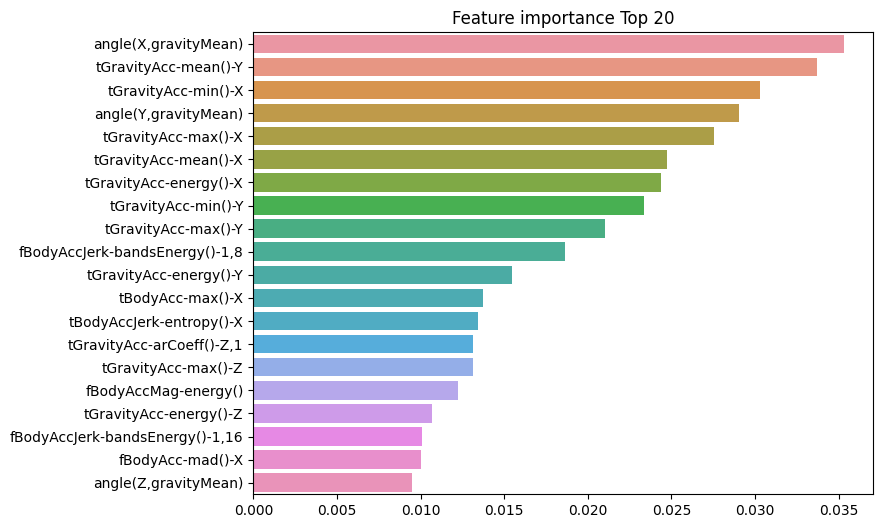

In [14]:
import matplotlib.pyplot as plt
import seaborn as sb

ftr_importance_values = rf2.feature_importances_
ftr_importances = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importance Top 20')
sb.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()